In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

import os

In [2]:
# create directories to store link and weight randomised networks corresponding 
# to our proposed strahler method reconstructed networks

path = "./random network/"
if not os.path.isdir(path):
    os.mkdir(path)

for i in range(8):
    path = "./random network/janelia_Comm%d"%i
    if not os.path.isdir(path):
        os.mkdir(path)
    
    for type in ["link random", "weight random"]:
        path = "./random network/janelia_Comm%d/"%i+type
        if not os.path.isdir(path):
            os.mkdir(path)

        # pr refers to proximity range 1um and 5um.
        for pr in [1,5]:
            path = "./random network/janelia_Comm%d/%s/network_%.1fum"%(i,type,pr)
            if not os.path.isdir(path):
                os.mkdir(path)


In [4]:
# this function takes the network as input and randomises the link connection of the nodes
# finally outputs dataframe consisting randomised edges hence link randomised network
# here both the link connection changes as well as weight changes.

def link_randomization(G, df):
    n_edges = G.number_of_edges()

    # setting the number of swaps based on documentation provided for function nx.directed_edge_swap()
    G_rand = nx.directed_edge_swap(G, nswap = int(n_edges/3),\
                                   max_tries=int(n_edges/3)*1000)

    df_rand = pd.DataFrame(list(G_rand.edges()), columns=["bodyId_pre","bodyId_post"])
    weight_list = np.zeros(len(df_rand), dtype=int)
    
    for source in np.unique(df_rand.bodyId_pre.to_list()):
        
        source_ind =  np.argwhere(np.array(df_rand.bodyId_pre.to_list())==source).flatten() 
        
        if source in df.bodyId_pre.to_list():
            weight_samples = df[df.bodyId_pre==source].weight.to_list()
            
            np.random.shuffle(weight_samples)
            weight_list[source_ind] = weight_samples
        
        else: # sample from weight distribution if source not in list
            weights = df.weight.to_list()
            n = len(weights)
            
            cdf = nx.utils.cumulative_distribution(weights)  # cdf of degree
            discrete_sequence = nx.utils.discrete_sequence
        
            sampled_indices = discrete_sequence(n, cdistribution=cdf)
            
            weight_samples = np.array(weights)[sampled_indices]

            weight_list[source_ind] = weight_samples
    # insert new column to dataframe
    df_rand["weight"] = weight_list
    return df_rand
    

In [5]:
# this function takes the dataframe of network edges as input and randomly assigns the weight to the links.
# The links between the edges are kept fixed but only the weights are rearranged.

# finally outputs dataframe consisting weight randomised edges hence weight randomised network

def weight_randomization(df):
    # columns: bodiId_pre, body_ID_post, weight
    weight_list = df.weight.to_list()
    n = len(weight_list)
    
    cdf = nx.utils.cumulative_distribution(weight_list)  # cdf of weight
    discrete_sequence = nx.utils.discrete_sequence

    sampled_indices = discrete_sequence(n, cdistribution=cdf)
    
    new_weight_list = np.array(weight_list)[sampled_indices]

    # Replace the 'weight' column with the new values
    df.loc[:, 'weight'] = new_weight_list
    return df

    

In [6]:
%%time
# Data collection of random networks

# store 100 realisations of link and weight randomised networks considering networks with proximity range
# 1um and 5um. 

realizations=100

for j in range(8):
    print("Comm %d"%j)
            
    for pr in [1, 5]:
        print("pr", pr)
        
        #print("prox range: %.1f um"%pr)
        nodes = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%j).Node.to_list()
        path = "./janelia_Comm%d/"%j
        
        df_network = pd.read_csv(path+"network_%.1fum.txt"%pr, sep="\t", header=None)
        df_network = df_network.rename(columns={0: "bodyId_pre", 1: "bodyId_post", 2:"weight"})
        
        nodeA_list = df_network.bodyId_pre.tolist()
        nodeB_list = df_network.bodyId_post.tolist()
        weight_list = df_network.weight.tolist()
        
        # creating an edge list from adjacency matrix
        edge_list=[]
        for l,m,w in zip(nodeA_list, nodeB_list, weight_list):
            edge_list.append( (l,m,{"weight":w}))
            
        G = nx.DiGraph()
        
        # Add all the nodes to the graph
        G.add_nodes_from(nodes)
        # Add all the edges to the graph
        G.add_edges_from(edge_list)
        
        for type in ["link random", "weight random"]:
            if type=="link random":
                rand_path = "./random network/janelia_Comm%d/%s/network_%.1fum/"%(j,type,pr)
                
                for k in range(realizations):
                    df_link_rand = link_randomization(G, df_network)
                    df_link_rand.to_csv(rand_path+"%d.csv"%k, index=False)
                
            elif type=="weight random":    
                rand_path = "./random network/janelia_Comm%d/%s/network_%.1fum/"%(j,type,pr)
                for k in range(realizations):
                    df_weight_rand = weight_randomization(df_network)
                    df_link_rand.to_csv(rand_path+"%d.csv"%k, index=False)


Comm 0
pr 1
pr 5
Comm 1
pr 1
pr 5
Comm 2
pr 1
pr 5
Comm 3
pr 1
pr 5
Comm 4
pr 1
pr 5
Comm 5
pr 1
pr 5
Comm 6
pr 1
pr 5
Comm 7
pr 1
pr 5
CPU times: user 19h 7min 20s, sys: 33min 19s, total: 19h 40min 40s
Wall time: 19h 43min 40s


# Community detection applied on random networks

In [7]:
# create directories to store communities of random networks

for i in range(8):
    path = "./random network/janelia_Comm%d"%i
    if not os.path.isdir(path):
        os.mkdir(path)
    
    for type in ["link random", "weight random"]:
        path = "./random network/janelia_Comm%d/"%i+type
        if not os.path.isdir(path):
            os.mkdir(path)
        
        for pr in [1,5]:
            path = "./random network/janelia_Comm%d/%s/network_%.1fum_modules"%(i,type,pr)
            if not os.path.isdir(path):
                os.mkdir(path)


In [8]:
import leidenalg
import igraph as ig
from collections import Counter

def Community_save(Graph, membership, filename):    
    df = pd.DataFrame()
    df['Node'] = Graph.vs['_nx_name']
    df['Community'] = np.array(membership).astype(int)
    
    df.to_csv(filename+".csv", index=False)
    return df

In [9]:
# Convert dataframe to networkx graph object
def df_to_graph(nodes, df):
    nodeA_list = df.bodyId_pre.tolist()
    nodeB_list = df.bodyId_post.tolist()
    weight_list = df.weight.tolist()

    G = nx.DiGraph()
    
    # Add all the nodes to the graph
    G.add_nodes_from(nodes)
    
    # creating an edge list from adjacency matrix
    edge_list=[]
    for l,m,w in zip(nodeA_list, nodeB_list, weight_list):
        if (l in nodes) and (m in nodes):
            #edge_list.append( (l,m,w))
            G.add_edge(l, m, weight=w)
            
    # Add all the edges to the graph
    #G.add_weighted_edges_from(edge_list)
    return G


In [13]:
import multiprocess
from functools import partial

# function to save communities information
# arguments meaning:
# k: index for number of realisations 0 to 99
# j: module number 0 to 7
# type: link randomisation or weight randomisation
# pr: specify proximity range 1um or 5um
def save_comm_file(k, j, type, pr):
    
    path = "./random network/janelia_Comm%d/%s/network_%.1fum/"%(j,type,pr)
    
    df_network = pd.read_csv(path+"%d.csv"%k)
    
    nodeA_list = df_network.bodyId_pre.tolist()
    nodeB_list = df_network.bodyId_post.tolist()
    weight_list = df_network.weight.tolist()
    
    nodes = pd.read_csv("./EM_communities/averageSubComm%d_drosophilia.csv"%j).Node.to_list()
            
    G = df_to_graph(nodes, df_network)
    
    G_ig = ig.Graph.from_networkx(G)
    #try:
    comm_membership = leidenalg.find_partition(G_ig,\
                                       leidenalg.ModularityVertexPartition,\
                                       weights="weight")
    #except Exception as e:
    #    print(k, j, type, pr)

    save_path = "./random network/janelia_Comm%d/%s/network_%.1fum_modules/"%(j,type,pr)
        
    Community_save(G_ig, comm_membership.membership, save_path+"%d"%k)

    return None 



In [14]:
%%time

# parallelise applying community detection to each random network
realizations=100

for j in range(8):
    print("Comm", j)

    for type in ["link random", "weight random"]:

        for pr in [1,5]:

            parallelised_func = partial( save_comm_file, j=j, type=type, pr=pr)
        
            pool = multiprocess.Pool( 7 )
            _ = pool.map(parallelised_func, range(realizations))
            pool.close()
            pool.join()


Comm 0
Comm 1
Comm 2
Comm 3
Comm 4
Comm 5
Comm 6
Comm 7
CPU times: user 480 ms, sys: 601 ms, total: 1.08 s
Wall time: 1h 41min 58s


# Compute ARI and NMI between communities 0-7 of EM drosophilia and reconstructed communities 0-7 from our proposed method 

### For example, it considers partition(set of subcommunities) of community 0 of EM drosophilia and partition of reconstructed community 0 using our method(strahler-threshold-proximity)


ARI: Adjusted Rank Index


NMI: Normalised Mutual Information


In [2]:
# partition refers to set of community sets
def ari_manual(partition1, partition2):
    # partition2: dict with key:value 
    # key: leiden algorithm detected comme, value: node numbers
    
    # Check:
    if sum([len(value) for value in partition2.values() ])!=sum([len(value) for value in partition1.values() ]):
        print("total nodes of both partitions do not match!")
        return 
    
    n = sum([len(value) for value in partition2.values() ])
    nc2 = lambda x: x*(x-1)/2.0
    
    t1=0
    for value1 in partition1.values():
        for value2 in partition2.values():
            nij = len(set(value1).intersection(set(value2)))
            t1+=nc2(nij)
    
    t2 = 0        
    for value1 in partition1.values():
        ni_plus = len(value1)
        t2+=nc2(ni_plus)    
    
    t3 = 0        
    for value2 in partition2.values():
        nj_plus = len(value2)
        t3+=nc2(nj_plus)    
    
    ari  = ( t1 - (t2*t3/nc2(n)) ) /( 0.5*(t2+t3)- t2*t3/nc2(n))        
    return ari
    

# this function inputs node-mapping-to-community file to dictionary
# with keys as community numbers and values as list of nodes within the community
def community_nodeNumbers_dict(comm_detection_file, main_comm=None): 
        df_comm = pd.read_csv(comm_detection_file)
        comm_node_dict = {}
        # UC only 7+1 communities
        if main_comm==None:
            main_comm = len(df_comm.Community.unique())
            
        for i in np.sort(df_comm.Community.unique())[:main_comm].astype(int):

            comm_node_dict["C"+str(i+1)] = df_comm[df_comm.Community == i].Node.tolist()
        
        return comm_node_dict



def nmi_manual(partition1, partition2):
    # partition2: dict with key:value 
    # key: leiden algorithm detected comme, value: node numbers
    
    # Check:
    if sum([len(value) for value in partition2.values() ])!=sum([len(value) for value in partition1.values() ]):
        print("total nodes of both partitions do not match!")
        return 
    
    n = sum([len(value) for value in partition2.values() ])
    #print(n)
    I_matrix = np.zeros((len(partition1), len(partition2)))
    pij_matrix = np.zeros((len(partition1), len(partition2)))
    
    i=0
    for value1 in partition1.values():
        ni_plus = len(value1)
        j=0
        for value2 in partition2.values():
            nj_plus = len(value2)
            nij = len(set(value1).intersection(set(value2)))
            
            pij_matrix[i,j] = nij/n
            j+=1
        i+=1
        
    for i in range(len(partition1.values())):
        pi_plus = np.sum(pij_matrix[i,:])
        
        for j in range(len(partition2.values())):
            pj_plus = np.sum(pij_matrix[:,j])
            
            if pij_matrix[i,j]!=0:
                I_matrix[i,j] = -2*pij_matrix[i,j]*np.log2( pij_matrix[i,j]/(pi_plus*pj_plus)) 
            else:
                I_matrix[i,j] = 0.0
                
    nmi = np.sum(I_matrix)/(np.sum(np.sum(pij_matrix,axis=0)*np.log2(np.sum(pij_matrix,axis=0) ))+\
                            np.sum(np.sum(pij_matrix,axis=1)*np.log2(np.sum(pij_matrix,axis=1) )))
    
    return nmi
    


## Steps involved:
1. Consider partition of module i of EM drosophilia and partition of module i reconstructed by our method(can be network reconstructed with prox. rang 1um and 5um).
2. Compute similarity measures like ARI and NMI between these two partitions, for networks with prox ranges 1um, 5um and store the information as a dataframe df_ari_nmi

In [9]:

def sim_mean_std_rand(compute_similarity, j, type, pr):
    path = "./random network/janelia_Comm%d/%s/network_%.1fum_modules/"%(j,type,pr)
    sim_measure = []
    #print(j, type, pr)
    for k in range(realizations):
        
        # EM partitions
        P1 = community_nodeNumbers_dict("./EM_communities/averageSubComm%d_drosophilia.csv"%j)

        # strahler partitions
        P2 = community_nodeNumbers_dict(path+"%d.csv"%k)

        if compute_similarity=='ari':
            sim_measure.append(ari_manual(P1, P2))
            
        elif compute_similarity=='nmi':
            sim_measure.append(nmi_manual(P1, P2))

    return np.mean(sim_measure), np.std(sim_measure)

In [12]:
%%time
# computes the ari and nmi between module i of EM drosophilia and module i of reconstructed network 
# with proximty range 1um and 5um
realizations=100
ari_1um = []
ariMean_linkRand_1um = []
ariStd_linkRand_1um = []
ariMean_weightRand_1um = []
ariStd_weightRand_1um = []

nmi_1um = []
nmiMean_linkRand_1um = []
nmiStd_linkRand_1um = []
nmiMean_weightRand_1um = []
nmiStd_weightRand_1um = []

ari_5um = []
ariMean_linkRand_5um = []
ariStd_linkRand_5um = []
ariMean_weightRand_5um = []
ariStd_weightRand_5um = []

nmi_5um = []
nmiMean_linkRand_5um = []
nmiStd_linkRand_5um = []
nmiMean_weightRand_5um = []
nmiStd_weightRand_5um = []

for pr in [1,5]:
    
    for l in range(8):
    
        path = "./janelia_Comm%d/"%l
        
        # EM partitions, found by applying leiden algorithm to each of the 8 modules
        P1 = community_nodeNumbers_dict("./EM_communities/averageSubComm%d_drosophilia.csv"%l)
        
        # strahler partitions, found by applying leiden algorithm to each of the 8 reconstructed subnetworks
        P2 = community_nodeNumbers_dict(path+"SubComm%d_reconstructed_%.1fum.csv"%(l,pr))

        if pr==1:
            ari_1um.append(ari_manual(P1, P2))
            nmi_1um.append(nmi_manual(P1, P2))
            
            mean, std = sim_mean_std_rand('ari', l, 'link random', pr)
            ariMean_linkRand_1um.append(mean)
            ariStd_linkRand_1um.append(std)
            
            mean, std = sim_mean_std_rand('ari', l, 'weight random', pr)
            ariMean_weightRand_1um.append(mean)
            ariStd_weightRand_1um.append(std)
            
            
            mean, std = sim_mean_std_rand('nmi', l, 'link random', pr)
            nmiMean_linkRand_1um.append(mean)
            nmiStd_linkRand_1um.append(std)

            mean, std = sim_mean_std_rand('nmi', l, 'weight random', pr)
            nmiMean_weightRand_1um.append(mean)
            nmiStd_weightRand_1um.append(std)        

        if pr==5:
            ari_5um.append(ari_manual(P1, P2))
            nmi_5um.append(nmi_manual(P1, P2))

            mean, std = sim_mean_std_rand('ari', l, 'link random', pr)
            ariMean_linkRand_5um.append(mean)
            ariStd_linkRand_5um.append(std)
            
            mean, std = sim_mean_std_rand('ari', l, 'weight random', pr)
            ariMean_weightRand_5um.append(mean)
            ariStd_weightRand_5um.append(std)
            
            
            mean, std = sim_mean_std_rand('nmi', l, 'link random', pr)
            nmiMean_linkRand_5um.append(mean)
            nmiStd_linkRand_5um.append(std)

            mean, std = sim_mean_std_rand('nmi', l, 'weight random', pr)
            nmiMean_weightRand_5um.append(mean)
            nmiStd_weightRand_5um.append(std)



CPU times: user 30.6 s, sys: 590 ms, total: 31.2 s
Wall time: 31.8 s


In [14]:
df_ari_nmi = pd.DataFrame({"modules":["Module %d"%i for i in range(8)],
             "ARI 1um PR":ari_1um, "ARI 5um PR":ari_5um, 
             "NMI 1um PR":nmi_1um, "NMI 5um PR":nmi_5um})
df_ari_nmi

,modules,ARI 1um PR,ARI 5um PR,NMI 1um PR,NMI 5um PR
0,Module 0,0.398597,0.335102,0.545878,0.478728
1,Module 1,0.492287,0.497637,0.480612,0.503364
2,Module 2,0.353474,0.339324,0.414008,0.383208
3,Module 3,0.320013,0.324788,0.408120,0.409431
4,Module 4,0.192703,0.199708,0.253015,0.257254
5,Module 5,0.040915,0.037897,0.103048,0.098076
6,Module 6,0.486276,0.527616,0.514384,0.521734
7,Module 7,0.604465,0.602411,0.548925,0.558782


In [28]:
df_ari_nmi.to_latex()

'\\begin{tabular}{llrrrr}\n\\toprule\n & modules & ARI 1um PR & ARI 5um PR & NMI 1um PR & NMI 5um PR \\\\\n\\midrule\n0 & Module 0 & 0.398597 & 0.335102 & 0.545878 & 0.478728 \\\\\n1 & Module 1 & 0.492287 & 0.497637 & 0.480612 & 0.503364 \\\\\n2 & Module 2 & 0.353474 & 0.339324 & 0.414008 & 0.383208 \\\\\n3 & Module 3 & 0.320013 & 0.324788 & 0.408120 & 0.409431 \\\\\n4 & Module 4 & 0.192703 & 0.199708 & 0.253015 & 0.257254 \\\\\n5 & Module 5 & 0.040915 & 0.037897 & 0.103048 & 0.098076 \\\\\n6 & Module 6 & 0.486276 & 0.527616 & 0.514384 & 0.521734 \\\\\n7 & Module 7 & 0.604465 & 0.602411 & 0.548925 & 0.558782 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [15]:
df_mean_std = pd.DataFrame({"modules":["Module %d"%(i+1) for i in range(8)],
             "ARI 1um PR":ari_1um, 
            "ariMean_linkRand_1um":ariMean_linkRand_1um,
            "ariStd_linkRand_1um":ariStd_linkRand_1um,
            "ariMean_weightRand_1um":ariMean_weightRand_1um,
            "ariStd_weightRand_1um":ariStd_weightRand_1um,
           
            "ARI 5um PR":ari_5um, 
           "ariMean_linkRand_5um":ariMean_linkRand_5um,
            "ariStd_linkRand_5um":ariStd_linkRand_5um,
            "ariMean_weightRand_5um":ariMean_weightRand_5um,
            "ariStd_weightRand_5um":ariStd_weightRand_5um,
             
                            
            "NMI 1um PR":nmi_1um, 
           "nmiMean_linkRand_1um":nmiMean_linkRand_1um,
            "nmiStd_linkRand_1um":nmiStd_linkRand_1um,
            "nmiMean_weightRand_1um":nmiMean_weightRand_1um,
            "nmiStd_weightRand_1um":nmiStd_weightRand_1um,
                            
            "NMI 5um PR":nmi_5um,
            "nmiMean_linkRand_5um":nmiMean_linkRand_5um,
            "nmiStd_linkRand_5um":nmiStd_linkRand_5um,
            "nmiMean_weightRand_5um":nmiMean_weightRand_5um,
            "nmiStd_weightRand_5um":nmiStd_weightRand_5um
                           })

In [16]:
df_mean_std

,modules,ARI 1um PR,ariMean_linkRand_1um,ariStd_linkRand_1um,ariMean_weightRand_1um,ariStd_weightRand_1um,ARI 5um PR,ariMean_linkRand_5um,ariStd_linkRand_5um,ariMean_weightRand_5um,...,NMI 1um PR,nmiMean_linkRand_1um,nmiStd_linkRand_1um,nmiMean_weightRand_1um,nmiStd_weightRand_1um,NMI 5um PR,nmiMean_linkRand_5um,nmiStd_linkRand_5um,nmiMean_weightRand_5um,nmiStd_weightRand_5um
0,Module 1,0.398597,0.026325,0.025100,0.014135,0.002598,0.335102,0.001720,0.007590,0.000941,...,0.545878,0.047249,0.025894,0.035319,0.003281,0.478728,0.011300,0.009317,0.008817,0.000931
1,Module 2,0.492287,0.031899,0.037837,0.040584,0.005878,0.497637,0.003016,0.018036,0.000675,...,0.480612,0.044644,0.034767,0.045521,0.003910,0.503364,0.012870,0.019109,0.010474,0.001134
2,Module 3,0.353474,0.042762,0.038554,0.027302,0.014775,0.339324,0.001886,0.012423,0.000339,...,0.414008,0.037651,0.024369,0.030067,0.007882,0.383208,0.008613,0.007223,0.007766,0.001050
3,Module 4,0.320013,0.054720,0.071856,0.025299,0.004239,0.324788,0.005406,0.030591,0.000146,...,0.408120,0.069852,0.052525,0.047961,0.005204,0.409431,0.012120,0.030831,0.006399,0.000868
4,Module 5,0.192703,0.023575,0.004674,0.020256,0.003516,0.199708,0.001295,0.001425,0.000613,...,0.253015,0.053703,0.005666,0.047402,0.003247,0.257254,0.014089,0.002631,0.012477,0.000743
5,Module 6,0.040915,0.004752,0.009150,0.002823,0.000781,0.037897,0.011176,0.003448,0.012266,...,0.103048,0.013457,0.014550,0.010483,0.001210,0.098076,0.010686,0.002470,0.010470,0.001276
6,Module 7,0.486276,0.021560,0.028995,0.008966,0.002509,0.527616,0.001199,0.006795,-0.000391,...,0.514384,0.043254,0.024993,0.030088,0.002726,0.521734,0.015981,0.011033,0.014599,0.001613
7,Module 8,0.604465,0.180963,0.041628,0.199500,0.016076,0.602411,0.073226,0.053546,0.084500,...,0.548925,0.137370,0.026863,0.140082,0.005337,0.558782,0.071392,0.029576,0.071986,0.002637


In [17]:
df_mean_std.to_csv("ariNmi_randMean_std.csv",index=False)

In [26]:
# compute z-score dataframe for module 6 and module 8
df_zscore = pd.DataFrame({
    "modules":["Module %d"%(i+1) for i in range(8)],
    "ari_1um_link":(df_mean_std["ARI 1um PR"]-df_mean_std["ariMean_linkRand_1um"])/df_mean_std["ariStd_linkRand_1um"],
             "ari_1um_weight":(df_mean_std["ARI 1um PR"]-df_mean_std["ariMean_weightRand_1um"])/df_mean_std["ariStd_weightRand_1um"],
            
             "ari_5um_link":(df_mean_std["ARI 5um PR"]-df_mean_std["ariMean_linkRand_5um"])/df_mean_std["ariStd_linkRand_5um"],
             "ari_5um_weight":(df_mean_std["ARI 5um PR"]-df_mean_std["ariMean_weightRand_5um"])/df_mean_std["ariStd_weightRand_5um"],

             "nmi_1um_link":(df_mean_std["NMI 1um PR"]-df_mean_std["nmiMean_linkRand_1um"])/df_mean_std["nmiStd_linkRand_1um"],
             "nmi_1um_weight":(df_mean_std["NMI 1um PR"]-df_mean_std["nmiMean_weightRand_1um"])/df_mean_std["nmiStd_weightRand_1um"],
            
             "nmi_5um_link":(df_mean_std["NMI 5um PR"]-df_mean_std["nmiMean_linkRand_5um"])/df_mean_std["nmiStd_linkRand_5um"],
             "nmi_5um_weight":(df_mean_std["NMI 5um PR"]-df_mean_std["nmiMean_weightRand_5um"])/df_mean_std["nmiStd_weightRand_5um"],
            
            })

In [27]:
df_zscore

,modules,ari_1um_link,ari_1um_weight,ari_5um_link,ari_5um_weight,nmi_1um_link,nmi_1um_weight,nmi_5um_link,nmi_5um_weight
0,Module 1,14.831832,147.994471,43.926323,633.484472,19.256485,155.601836,50.171371,504.525894
1,Module 2,12.167762,76.844186,27.424318,1484.161645,12.539783,111.265491,25.668497,434.659509
2,Module 3,8.059108,22.076139,27.163112,746.505733,15.444288,48.710803,51.864136,357.398475
3,Module 4,3.692003,69.526330,10.440476,477.182914,6.440105,69.205463,12.886546,464.178747
4,Module 5,36.187199,49.052649,139.251347,508.657013,35.178956,63.315763,92.410145,329.256392
5,Module 6,3.952388,48.776051,7.749638,7.902015,6.157708,76.477074,35.382707,68.648080
6,Module 7,16.027318,190.273479,77.475190,710.910639,18.850182,177.641811,45.841545,314.480043
7,Module 8,10.173423,25.190338,9.882807,79.289780,15.320504,76.609622,16.479261,184.588401


In [29]:
df_zscore.to_csv("ari_nmi_zscores.csv", index=False)

# Computing Z-score
### The method for computing z-score is described in more details on the following links for reference:

https://github.com/netneurolab/conn2res/blob/master/examples/example1_figs.py

https://www.nature.com/articles/s41467-024-44900-4

## Steps for computing z-score of ARI and NMI:

1. Consider partition of module i of EM drosophilia and partition of module i reconstructed by our method(can be network reconstructed with prox. rang 1um and 5um).
2. Compute similarity measures like ARI and NMI between these two partitions, for networks with prox ranges 1um, 5um
3. For these above computed ARIs and NMIs, z-scores are computed on these measures using mean and standard deviations of ARIs/NMIs of random networks.
4. store the information as a dataframe df_ari_nmi 

In [25]:
import scipy.stats


# Steps for computing z-score of ARI and NMI, corresponding random networks and visualising through strip plots


1. Similar to computation of above, now ARI and NMI are computed using the (partitions-of)modules corresponding to randomised version of the reconstructed networks(prox range(pr) 1um and 5um) and (partitions-of)modules of EM drosphilia. 
2. For these above computed ARIs and NMIs, z-scores are computed on these measures using mean and standard deviations of ARIs/NMIs of random networks.
3. All these data are visualised as stripplot indicating how close or far the scattered black point corresponding to ARI/NMI of empirical model(our model i.e. df_ari_nmi) and other scattered points is from remaning ARIs/NMIs of randomised versions of networks.


In [33]:
# the function outputs:
# df: z-scores of ARI/NMI corresponding to random networks themselves
# df_emp: z-scores of ARI/NMI correspnding to model reconstructed networks

# list of aruguments as input to the function
# module_num: specify the community or module number 0 to 7
# compute_similarity: specify ARI or NMI, to specify the measure between two partitions 
# type: specify 'link random' or 'weight random' referring to random networks 
# realizations: 100  
# df_ari_nmi: dataframe consisting of ARIs/NMIs computed between module partitions of EM drosophilia 
# and reconstructed network

def get_emp_null_df(module_num, compute_similarity, type, realizations, df_ari_nmi):
    
    j = module_num
            
    sim_network_dict = {"1um":[], "5um":[]}

    # RANDOM NETWORKS
    # compute z-score of the ARI/NMI of the null models itself.
    for pr in [1,5]:
    
        path = "./random network/janelia_Comm%d/%s/network_%.1fum_modules/"%(j,type,pr)
        #print(j, type, pr)
        for k in range(realizations):
            # EM partitions
            P1 = community_nodeNumbers_dict("./EM_communities/averageSubComm%d_drosophilia.csv"%j)
    
            # strahler partitions
            P2 = community_nodeNumbers_dict(path+"%d.csv"%k)
    
            if compute_similarity=='ari':
                sim_network_dict["%dum"%pr].append(ari_manual(P1, P2))
            
            elif compute_similarity=='nmi':
                sim_network_dict["%dum"%pr].append(nmi_manual(P1, P2))
    
    df = pd.DataFrame({"network pr":["1um"]*realizations+["5um"]*realizations,
                    "sim_measure":sim_network_dict["1um"]+sim_network_dict["5um"]})
    
    # z-score null model values
    z_list = []
    for pr in [1,5]:
        df_network = df[df["network pr"]=="%dum"%pr]
        z_list+= list((df_network['sim_measure']-df_network['sim_measure'].mean())/df_network['sim_measure'].std())
    
    df['z-score'] = z_list



    ##############  EMPIRICAL DATAFRAME/MODEL RECONSTRUCTED NETWORKS   ####################
    emp_z_score_list = []
    pval_list = []
    
    for pr in [1,5]:
        if compute_similarity=="ari":
            res = df_ari_nmi.iloc[[j]]["ARI %dum PR"%pr].values[0]
        
        elif compute_similarity=="nmi":
            res = df_ari_nmi.iloc[[j]]["NMI %dum PR"%pr].values[0]
        
        df_network = df[df["network pr"]=="%dum"%pr]
        val = df_network["sim_measure"]
        z_score_emp = (res-np.mean(val))/np.std(val)
        
        emp_z_score_list.append(z_score_emp)
        
        # determine p-value
        count = len(np.where(df_network["z-score"].to_numpy() > z_score_emp)[0])
        n_nulls = len(df_network)
        pval_list.append( count / n_nulls )
    
    
    
    df_emp = pd.DataFrame( {"network pr":["1um", "5um"],
                          "z-score":emp_z_score_list,
                         "p-val":pval_list} )

    return df, df_emp


In [53]:
# visualising the z scores of our model(strahler-threshold-proximity based reconstructed network) 
# and randomised networks using striplots.

def striplot(module_num, compute_similarity, type, df, df_emp):
    j=module_num
    import seaborn as sns
    import warnings
    warnings.filterwarnings('ignore')
    
    # plot empirical vs null scores (z-scored) at critical alpha
    sns.set(style="ticks", font_scale=1.0)
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    
    sns.scatterplot(
        data=df_emp,
        x='network pr',
        y='z-score',
        s=30,
        c='black',
        ax=ax,
        
    )
    sns.stripplot(
        data=df,
        x='network pr',
        y='z-score',
        # width=0.5,
        s=2.5,
        jitter=0.3,
        ax=ax,
        
    )
    #ax.set_ylim(-3, 12.5)
    sns.despine(offset=10, trim=True,
                top=True, bottom=False,
                right=True, left=False)
    
    # print p-value
    label="1um p-val = %f \n5um p-val = %f"%(df_emp[df_emp["network pr"]=="1um"]["p-val"],
                                            df_emp[df_emp["network pr"]=="5um"]["p-val"])
    l1 = ax.plot([],[], label=label)
    
    # Add a legend with custom handles and labels
    ax.legend(bbox_to_anchor=(1.3, 0.9), loc='upper right', 
              prop={'size': 9}, handlelength=0)
    
    #plt.legend(loc='best')
    if type=="link random":
        plt.title("Module: %d"%(j+1)+", "+compute_similarity+", "+"Directed Configuration model", size=12)
    else: 
        plt.title("Module: %d"%(j+1)+", "+compute_similarity+", "+"weight randomization", size=12)
        
    #plt.show()
    image_path = "./random network/images/module%d/"%(j+1)
    plt.savefig(image_path+"mod%d_%s_%s.pdf"%(j+1, compute_similarity, type),\
                facecolor="white", bbox_inches="tight", dpi=600 )

In [52]:
image_path = "./random network/images/"
if not os.path.isdir(image_path):
    os.mkdir(image_path)
    
for j in range(8):
    image_path = "./random network/images/module%d"%(j+1)
    if not os.path.isdir(image_path):
        os.mkdir(image_path)
    
    

In [ ]:

realizations=100


for module_num in range(8):
    for compute_similarity in ['ari', 'nmi']:
        for type in ["link random", "weight random"]:

            df, df_emp = get_emp_null_df(module_num, compute_similarity, type, realizations, df_ari_nmi)
            striplot(module_num, compute_similarity, type, df, df_emp)
            plt.close()
            #print(df_emp)
            #print("")

# Re-plotting Module 6 and Module 8, ARI and NMI z-scores striplots


In [48]:
%%time
# pearson correlation strip plots
pr=5
realizations=100

## choose link random or weight random for z score and stripplot
type = "link random"
#type  = "weight random"
compute_similarity = "ari"

print("prox range: %.1f um"%pr)
sim_network_dict = {"Module 6":[], "Module 8":[]}
    
for mod_num in [5,7]:
    j=mod_num
    #corresponds to comunity 6, 8
    path = "./random network/janelia_Comm%d/%s/network_%.1fum_modules/"%(j,type,pr)

    for k in range(realizations):
        # EM partitions
        P1 = community_nodeNumbers_dict("./EM_communities/averageSubComm%d_drosophilia.csv"%j)

        # strahler partitions
        P2 = community_nodeNumbers_dict(path+"%d.csv"%k)

        if compute_similarity=='ari':
            sim_network_dict["Module %d"%(mod_num+1)].append(ari_manual(P1, P2))
        
        elif compute_similarity=='nmi':
            sim_network_dict["Module %d"%(mod_num+1)].append(nmi_manual(P1, P2))

        
df = pd.DataFrame({"Modules":["Module 6"]*realizations+["Module 8"]*realizations,
                "sim_measure":sim_network_dict["Module 6"]+sim_network_dict["Module 8"]})

# z-score null model pearson values
z_list = []
for mod_num in [5,7]:
    
    df_network = df[df["Modules"]=="Module %d"%(mod_num+1)]
    z_list+= list((df_network['sim_measure']-df_network['sim_measure'].mean())/df_network['sim_measure'].std())

df['z-score'] = z_list


prox range: 5.0 um
CPU times: user 603 ms, sys: 17.4 ms, total: 621 ms
Wall time: 619 ms


In [49]:
##############  EMPIRICAL DATAFRAME/MODEL RECONSTRUCTED NETWORKS   ####################
emp_z_score_list = []
pval_list = []
for mod_num in [5,7]:
    j=mod_num
    if compute_similarity=="ari":
        res = df_ari_nmi.iloc[[j]]["ARI %dum PR"%pr].values[0]
    
    elif compute_similarity=="nmi":
        res = df_ari_nmi.iloc[[j]]["NMI %dum PR"%pr].values[0]
    
    df_network = df[df["Modules"]=="Module %d"%(mod_num+1)]
    val = df_network["sim_measure"]
    z_score_emp = (res-np.mean(val))/np.std(val)
    
    emp_z_score_list.append(z_score_emp)
    
    # determine p-value
    count = len(np.where(df_network["z-score"].to_numpy() > z_score_emp)[0])
    n_nulls = len(df_network)
    pval_list.append( count / n_nulls )

df_emp = pd.DataFrame( {"Modules":["Module 6", "Module 8"],
                      "z-score":emp_z_score_list,
                     "p-val":pval_list} )


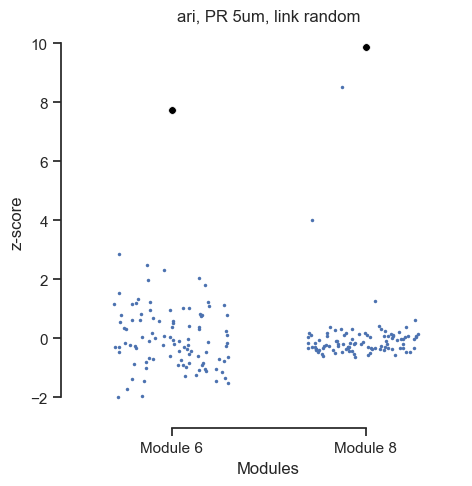

In [50]:
# visualising the z scores of our model(strahler-threshold-proximity based reconstructed network) 
# and randomised networks using striplots.

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# plot empirical vs null scores (z-scored) at critical alpha
sns.set(style="ticks", font_scale=1.0)
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

sns.scatterplot(
    data=df_emp,
    x='Modules',
    y='z-score',
    s=30,
    c='black',
    ax=ax,
    
)
sns.stripplot(
    data=df,
    x='Modules',
    y='z-score',
    # width=0.5,
    s=2.5,
    jitter=0.3,
    ax=ax,
    
)
#ax.set_ylim(-3, 12.5)
sns.despine(offset=10, trim=True,
            top=True, bottom=False,
            right=True, left=False)

image_path = "./ari_nmi_paper_images/"
if not os.path.isdir(image_path):
    os.mkdir(image_path)


plt.title("%s, PR %dum, %s"%(compute_similarity,pr,type), size=12)
    
plt.savefig(image_path+"%s_PR_%dum_%s.pdf"%(compute_similarity,pr,type),\
            facecolor="white", bbox_inches="tight", dpi=600 )